In [174]:
%pip install torch numpy matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 17.2 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [231]:
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

class MLAConfig:
    def __init__(self, dim=256, num_heads=4):
        self.dim = dim
        self.num_heads = num_heads
        self.per_head_dim = dim // num_heads
        self.dim_prime_compressed = self.per_head_dim*num_heads // 16
        self.dim_compressed = self.per_head_dim*num_heads // 16

# Create a default config object
config = MLAConfig()

class MultiHeadLatentAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.W_Q = nn.Linear(config.num_heads*config.per_head_dim, config.dim)
        self.W_K = nn.Linear(config.num_heads*config.per_head_dim, config.dim) 
        self.W_V = nn.Linear(config.num_heads*config.per_head_dim, config.dim)
        self.W_O = nn.Linear(config.dim, config.num_heads*config.per_head_dim)
        
        self.W_DKV = nn.Linear(config.dim, config.dim_compressed)
        self.W_UK = nn.Linear(config.dim_compressed, config.num_heads*config.per_head_dim)
        self.W_UV = nn.Linear(config.dim_compressed, config.num_heads*config.per_head_dim)
        
        self.W_DQ = nn.Linear(config.dim, config.dim_prime_compressed)
        self.W_UQ = nn.Linear(config.dim_prime_compressed, config.num_heads*config.per_head_dim)
        
        self.W_KR = nn.Linear(config.dim, config.dim)
        self.W_QR = nn.Linear(config.dim, config.dim)

        self.latent_kv = LatentKVAttention(config, self.W_DKV, self.W_UK, self.W_UV)
        self.latent_q = LatentQAttention(config, self.W_DQ, self.W_UQ)

        self.kr_cache = None
    
    def apply_rope(self, x, freq=10000.0, visualize=False, debug=False):
        # 1) Unpack the shape of the input
        batch_size, n_heads, seq_len, per_head_dim = x.shape
        assert per_head_dim % 2 == 0, "Head dimension must be even for pairwise RoPE."

        # 2) Create a position index [0, 1, 2, ..., seq_len-1]
        #    shape: (seq_len,)
        positions = torch.arange(seq_len)
        if debug:
            print("positions.shape", positions.shape)

        # 3) Create an index over the half-dimension. We treat each dimension i as paired (2i, 2i+1).
        #    shape: (per_head_dim//2,)
        dim_idx = torch.arange(per_head_dim // 2)
        if debug:
            print("dim_idx.shape", dim_idx.shape)

        # 4) Compute the "angle" or "theta" for each pair of dimensions:
        #    RoPE defines these angles as positions * (base_freq ^ (-2*i / d))
        #    where d is the total head dimension. We exponentiate freq in the negative direction.
        #    shape: (seq_len, per_head_dim//2)
        theta = positions.unsqueeze(1) * (freq ** (-2 * dim_idx / per_head_dim))
        if debug:
            print("theta.shape", theta.shape)

        # 5) Compute sin and cos for all positions and dimensions
        #    shape: both are (seq_len, per_head_dim//2)
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)

        # 6) Reshape cos/sin to allow broadcasting across (batch_size, n_heads)
        #    We want them to match the shape (batch_size, n_heads, seq_len, per_head_dim//2)
        #    when we broadcast. So we add dimensions:
        #    from (seq_len, per_head_dim//2) -> (1, 1, seq_len, per_head_dim//2)
        cos_theta = cos_theta.unsqueeze(0).unsqueeze(1)
        sin_theta = sin_theta.unsqueeze(0).unsqueeze(1)
        if debug:
            print("cos_theta.shape", cos_theta.shape)
            print("sin_theta.shape", sin_theta.shape)

        # 7) Reshape x so we can work with the final dimension as pairs: (..., 2)
        #    shape: (batch_size, n_heads, seq_len, per_head_dim//2, 2)
        x_reshaped = x.view(batch_size, n_heads, seq_len, per_head_dim // 2, 2)
        if debug:
            print("x_reshaped.shape", x_reshaped.shape)
        
        # Create lists to store original and rotated pairs for visualization
        original_pairs = []
        rotated_pairs = []
        
        # Collect original pairs from first head, first position
        for i in range(5):
            pair = (x_reshaped[0, 0, 0, i, 0].item(), x_reshaped[0, 0, 0, i, 1].item())
            original_pairs.append(pair)
            if debug: 
                print(f"Pair {i}: ({pair[0]:.4f}, {pair[1]:.4f})")

        # 8) Apply RoPE rotation:
        #    Let x_reshaped[..., 0] = x_even
        #        x_reshaped[..., 1] = x_odd
        #    shape: (batch_size, n_heads, seq_len, per_head_dim//2)
        #    Then:
        #       new_even = x_even * cos(theta) - x_odd * sin(theta)
        #       new_odd  = x_even * sin(theta) + x_odd * cos(theta)

        # Extract even and odd indices
        x_even = x_reshaped[..., 0]
        x_odd = x_reshaped[..., 1]
        if debug:
            print("x_even.shape", x_even.shape)
            print("x_odd.shape", x_odd.shape)

        # # Print some example pairs to visualize the structure
        # print("Example even/odd pairs from first head, first position:")
        # for i in range(5):
        #     print(f"Pair {i}: ({x_even[0, 0, i, 0].item():.4f}, {x_odd[0, 0, i, 0].item():.4f})")
        x_rotated_even = x_even * cos_theta - x_odd * sin_theta
        x_rotated_odd  = x_even * sin_theta + x_odd * cos_theta

        # Print some example pairs to visualize the structure
        for i in range(5):
            pair = (x_rotated_even[0, 0, i, 0].item(), x_rotated_odd[0, 0, i, 0].item())
            rotated_pairs.append(pair)
            if debug:
                print(f"Pair {i}: ({x_rotated_even[0, 0, i, 0].item():.4f}, {x_rotated_odd[0, 0, i, 0].item():.4f})")

        if visualize:
            # Create a figure with 5 subplots (one for each pair)
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))
            fig.suptitle('Rotary Position Embedding Visualizations', fontsize=16)

            # Colors for original and rotated vectors
            colors = ['blue', 'red']
            labels = ['Original', 'Rotated']

            # Plot each pair in its own subplot
            for i, (orig, rot) in enumerate(zip(original_pairs, rotated_pairs)):
                ax = axes[i]
                
                # Plot the original vector
                ax.arrow(0, 0, orig[0], orig[1], head_width=0.05, head_length=0.05, fc=colors[0], ec=colors[0], label=labels[0])
                
                # Plot the rotated vector
                ax.arrow(0, 0, rot[0], rot[1], head_width=0.05, head_length=0.05, fc=colors[1], ec=colors[1], label=labels[1])
                
                # Add a circle to visualize the rotation
                max_radius = max(np.sqrt(orig[0]**2 + orig[1]**2), np.sqrt(rot[0]**2 + rot[1]**2))
                circle = plt.Circle((0, 0), max_radius, fill=False, linestyle='--', alpha=0.3)
                ax.add_patch(circle)
                
                # Set equal aspect ratio and limits
                ax.set_aspect('equal')
                limit = max(max_radius, 0.8) * 1.2
                ax.set_xlim(-limit, limit)
                ax.set_ylim(-limit, limit)
                
                # Add grid and title
                ax.grid(True, alpha=0.3)
                ax.set_title(f'Pair {i}')
                
                # Add axes labels
                ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
                ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
                
                # Add legend (only for the first subplot)
                if i == 0:
                    ax.legend()

            plt.tight_layout()
            plt.show()

        # 9) Re-combine the rotated pairs into the last dimension
        #    shape still: (batch_size, seq_len, n_heads, per_head_dim // 2, 2)
        x_rotated = torch.stack([x_rotated_even, x_rotated_odd], dim=-1)
        if debug:
            print("x_rotated.shape", x_rotated.shape)

        # # 10) Reshape x_rotated to match the original shape
        # #    shape: (batch_size, seq_len, n_heads, per_head_dim)
        x_rotated = x_rotated.view(batch_size, n_heads, seq_len, per_head_dim)
        return x_rotated

    
    def kr(self, h):
        k_R_t_new = self.W_KR(h)
        if self.kr_cache is None:
            print("No KR cache")
            k_R_t = k_R_t_new
        else:
            print("KR cache")
            k_R_t = torch.cat([self.kr_cache, k_R_t_new], dim=1)

        self.kr_cache = k_R_t
        print("KR cache shape:", self.kr_cache.shape, "k_R_t shape:", k_R_t.shape)

        batch_size, seq_len, dim = k_R_t.shape    
        #(batch_size, seq_len, n_heads, per_head_dim)
        k_R_t = k_R_t.view(batch_size, seq_len, config.num_heads, config.per_head_dim).transpose(1, 2)
        k_R_t = self.apply_rope(k_R_t, visualize=True)
        print("k_R_t.shape", k_R_t.shape)

        return k_R_t

    def forward(self, h):
        k_C_t, v_C_t = self.latent_kv(h)

        k_R_t = self.kr(h)
        batch_size, seq_len, dim = k_C_t.shape
        k_C_t = k_C_t.view(batch_size, seq_len, config.num_heads, config.per_head_dim).transpose(1, 2)
        print("k_C_t.shape", k_C_t.shape)

        k_t = torch.cat([k_C_t, k_R_t], dim=-1)
        print("k_t.shape", k_t.shape)

        batch_size, seq_len, dim = v_C_t.shape
        v_C_t = v_C_t.view(batch_size, seq_len, config.num_heads, config.per_head_dim).transpose(1, 2)
        print("v_C_t.shape", v_C_t.shape)

        q_C_t = self.latent_q(h)
        print("q_C_t.shape", q_C_t.shape)

        batch_size, seq_len, dim = q_C_t.shape
        q_C_t = q_C_t.view(batch_size, seq_len, config.num_heads, config.per_head_dim).transpose(1, 2)
        print("q_C_t.shape", q_C_t.shape)

        q_R_t = self.apply_rope(q_C_t, visualize=True)
        print("q_R_t.shape", q_R_t.shape)

        q_t = torch.cat([q_C_t, q_R_t], dim=-1)
        print("q_t.shape", q_t.shape)
        
class LatentKVAttention(nn.Module):
    def __init__(self, config, W_DKV, W_UK, W_UV):
        super().__init__()

        self.W_DKV = W_DKV
        self.W_UK = W_UK
        self.W_UV = W_UV

        self.kv_cache = None
    
    def forward(self, h):
        c_KV_t_new = self.W_DKV(x)

        if self.kv_cache is None:
            print("No KV cache")
            c_KV_t = c_KV_t_new
        else:
            print("KV cache")
            c_KV_t = self.kv_cache
            c_KV_t = torch.cat([c_KV_t, c_KV_t_new], dim=1)

        self.kv_cache = c_KV_t
        print("KV cache shape:", self.kv_cache.shape, "c_KV_t shape:", c_KV_t.shape)

        k_C_t = self.W_UK(c_KV_t)
        v_C_t = self.W_UV(c_KV_t)

        return k_C_t, v_C_t

class LatentQAttention(nn.Module):
    def __init__(self, config, W_DQ, W_UQ):
        super().__init__()
        self.W_DQ = W_DQ
        self.W_UQ = W_UQ

    def forward(self, h):
        c_Q_t = self.W_DQ(h)
        q_C_t = self.W_UQ(c_Q_t)
        return q_C_t



Input tensor shape: torch.Size([2, 10, 256])
No KV cache
KV cache shape: torch.Size([2, 10, 16]) c_KV_t shape: torch.Size([2, 10, 16])
No KR cache
KR cache shape: torch.Size([2, 10, 256]) k_R_t shape: torch.Size([2, 10, 256])


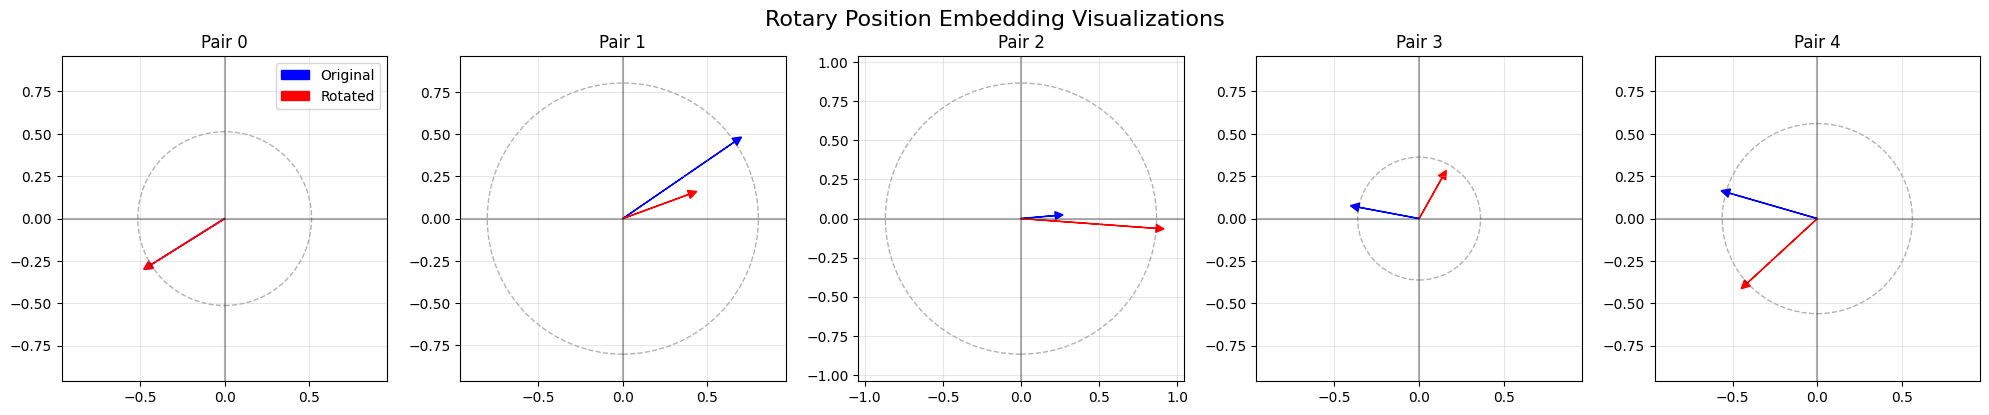

k_R_t.shape torch.Size([2, 4, 10, 64])
k_C_t.shape torch.Size([2, 4, 10, 64])
k_t.shape torch.Size([2, 4, 10, 128])
v_C_t.shape torch.Size([2, 4, 10, 64])
q_C_t.shape torch.Size([2, 10, 256])
q_C_t.shape torch.Size([2, 4, 10, 64])


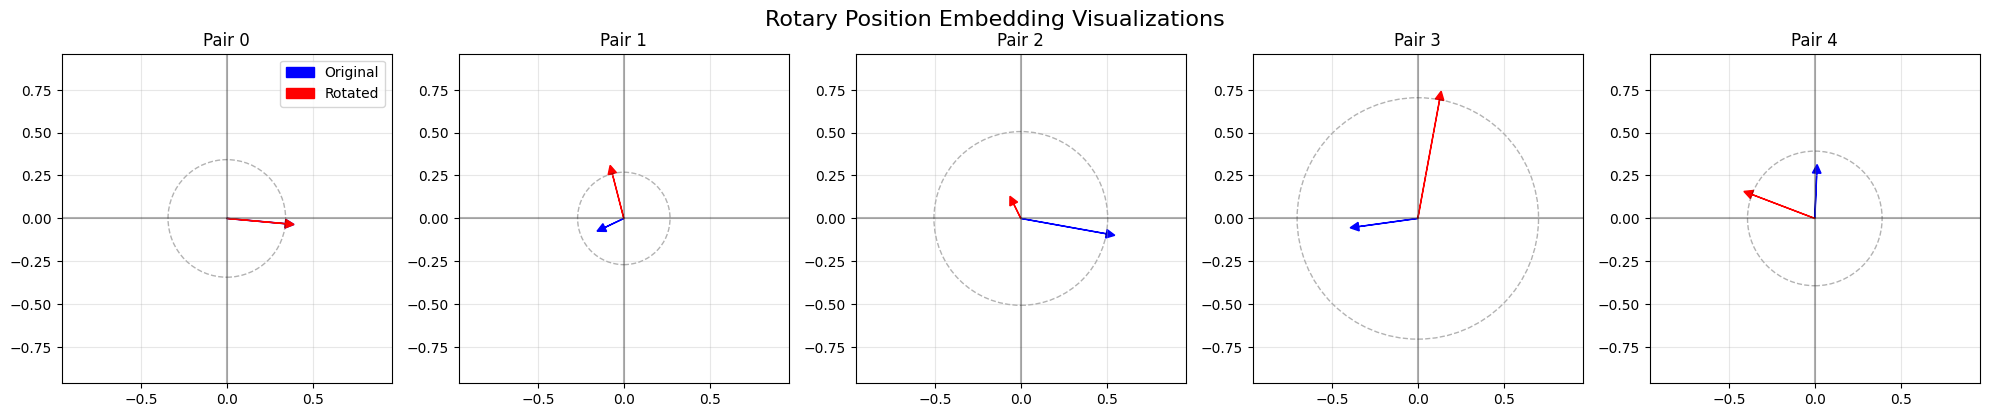

q_R_t.shape torch.Size([2, 4, 10, 64])
q_t.shape torch.Size([2, 4, 10, 128])


In [232]:
import torch
from torch import nn

# Setup example parameters
batch_size = 2
seq_len = 10

# Create a random input tensor using the config dimensions
x = torch.randn(batch_size, seq_len, config.dim)
print(f"Input tensor shape: {x.shape}")  # Should be [2, 10, 256] with default config

# Create an instance of the model
model = MultiHeadLatentAttention(config)
out = model(x)


In [50]:
x = torch.randn(batch_size, 1, config.dim)
k_C_t, v_C_t = model(x)

KV cache
torch.Size([2, 22, 16]) torch.Size([2, 22, 16])
